In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.filters import meijering, sato, frangi, hessian
from skimage.measure import label, regionprops
from sklearn import decomposition
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks
import helpers

In [2]:
filename = 'benoitdata/F20_10_b/6um_jamtveit_att_pag-1.99_3.12_00030.tif'
im = Image.open(filename)
imarr = np.array(im)

In [3]:
imarr_maskradius = helpers.remove_data_based_on_radius(imarr, mask_value=np.nan)

In [4]:
imarr_blur = gaussian_filter(imarr_maskradius, sigma=1)

In [5]:
h, e = np.histogram(imarr_blur[~np.isnan(imarr_blur)].flatten(), bins=1000)

In [6]:
peaks, other = find_peaks(h, height=1e3, width=4)

In [7]:
means = e[peaks]
stds = np.std(imarr_blur[~np.isnan(imarr_blur)].flatten())/3
stds

577.5227912101359

Text(25173.40700120378, 10.0, 'peak 2')

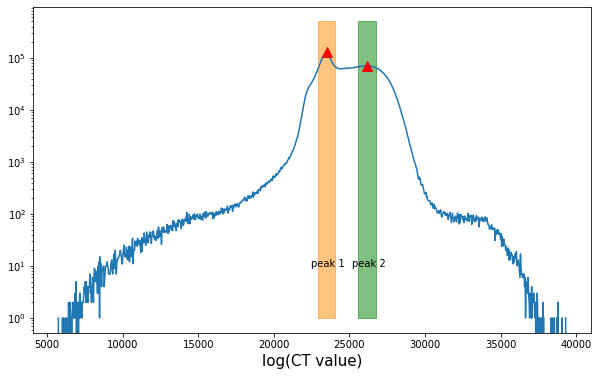

In [83]:
fig, ax = plt.subplots(figsize=(10, 6))

# x = np.log10(e[:-1])
x = e[:-1]

ax.plot(x, h)
ax.set_yscale('log')
ax.set_xlabel('log(CT value)', fontsize=15)
# ax.set_ylim(1e1, 1e8)

ax.plot(x[peaks], h[peaks], marker='^', markersize=10, linewidth=0, color='red')

ax.fill_between([means[0]-stds, means[0]+stds], 1e0, 5e5, color='darkorange', alpha=0.5)

ax.fill_between([means[1]-stds, means[1]+stds], 1e0, 5e5, color='green', alpha=0.5)

ax.text(s='peak 1', x=means[0]-1000, y=1e1)
ax.text(s='peak 2', x=means[1]-1000, y=1e1)

In [40]:
# TODO : why does this work when its imarr and imarr_blur
#        but doesn't work when using all the same array?

peak1mask = (imarr < means[0]+stds) & (imarr_blur > means[0]-stds).astype(int)

peak2mask = (imarr < means[1]+stds) & (imarr_blur > means[1]-stds).astype(int)

/home/john/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/home/john/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


2


'\nAt this point it seems like I can label the vesicles\nwhich appear as 0 valued here.\n\nI just need to connect the dots that are the same.\n'

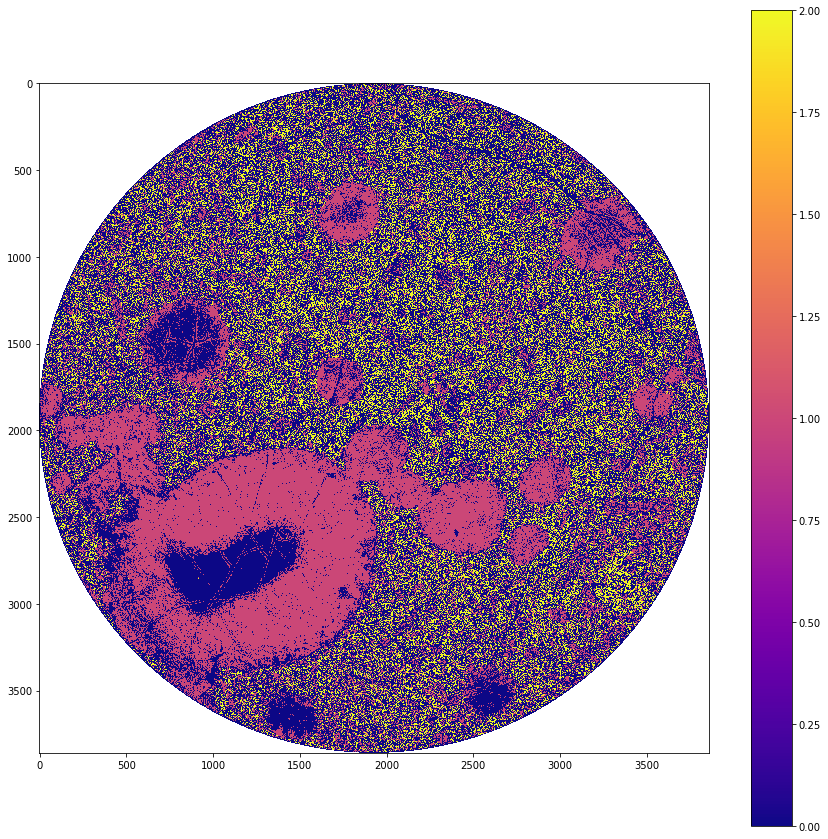

In [41]:
# returns indices where peak1mask is 1
x1, y1 = peak1mask.nonzero()

zeros = np.zeros_like(imarr)
zeros[x1, y1] = 1


x2, y2 = peak2mask.nonzero()
zeros[x2, y2] = 2

print(zeros.max())

fig, ax = plt.subplots(figsize=(15, 15))

imlabeled = helpers.remove_data_based_on_radius(zeros, mask_value=np.nan)


# cbar = ax.imshow(imlabeled, cmap='plasma')
cbar = ax.imshow(imlabeled, cmap='plasma')

fig.colorbar(cbar)

"""
At this point it seems like I can label the vesicles
which appear as 0 valued here.

I just need to connect the dots that are the same.
"""

In [43]:
from scipy import ndimage

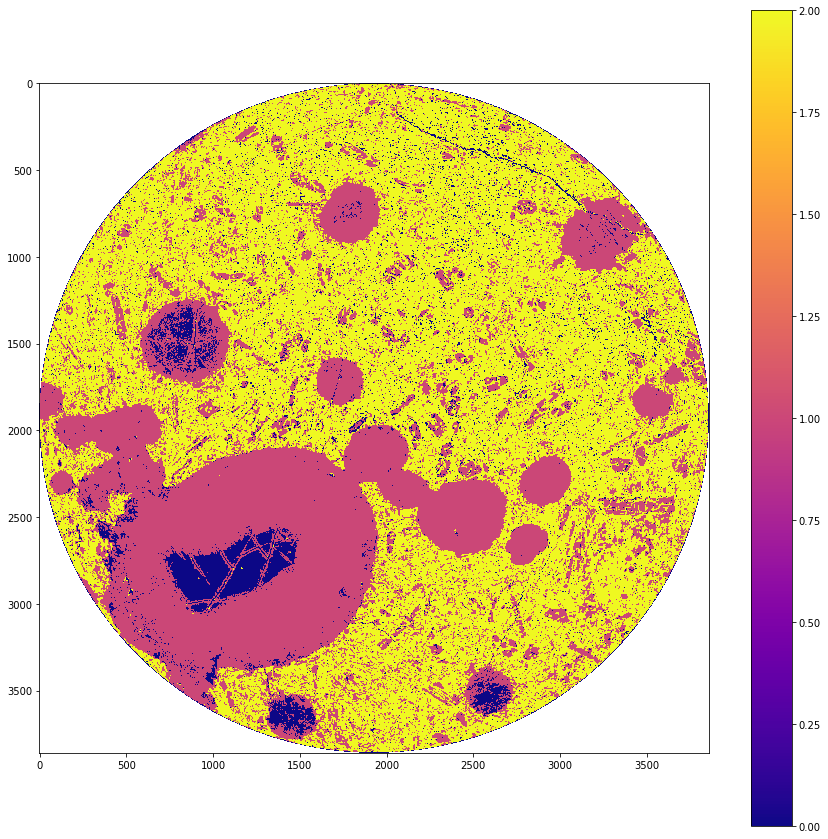

In [78]:
# footprint condition says value should be greater
# in all directions
footprint1 = np.array(
    [[1, 1, 1]
    ,[1, 0, 1]
    ,[1, 1, 1]]
)

footprint2 = np.array(
    [[1, 1, 1, 1, 1]
    ,[1, 1, 1, 1, 1]
    ,[1, 1, 0, 1, 1]
    ,[1, 1, 1, 1, 1]
    ,[1, 1, 1, 1, 1]]
)

# creates a window based on the given footprint
# to compare neighbors and replace values on 
# nearest maximum value
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.maximum_filter.html
newim = ndimage.maximum_filter(zeros, footprint=footprint2, mode='constant')
# newim = ndimage.maximum_filter(newim, footprint=footprint1, mode='constant')
# newim = ndimage.maximum_filter(newim, footprint=footprint, mode='constant')
# newim = ndimage.maximum_filter(newim, footprint=footprint, mode='constant')

fig, ax = plt.subplots(figsize=(15, 15))

imlabeled = helpers.remove_data_based_on_radius(newim, mask_value=np.nan)

# cbar = ax.imshow(imlabeled, cmap='plasma')
cbar = ax.imshow(imlabeled, cmap='plasma')

fig.colorbar(cbar)


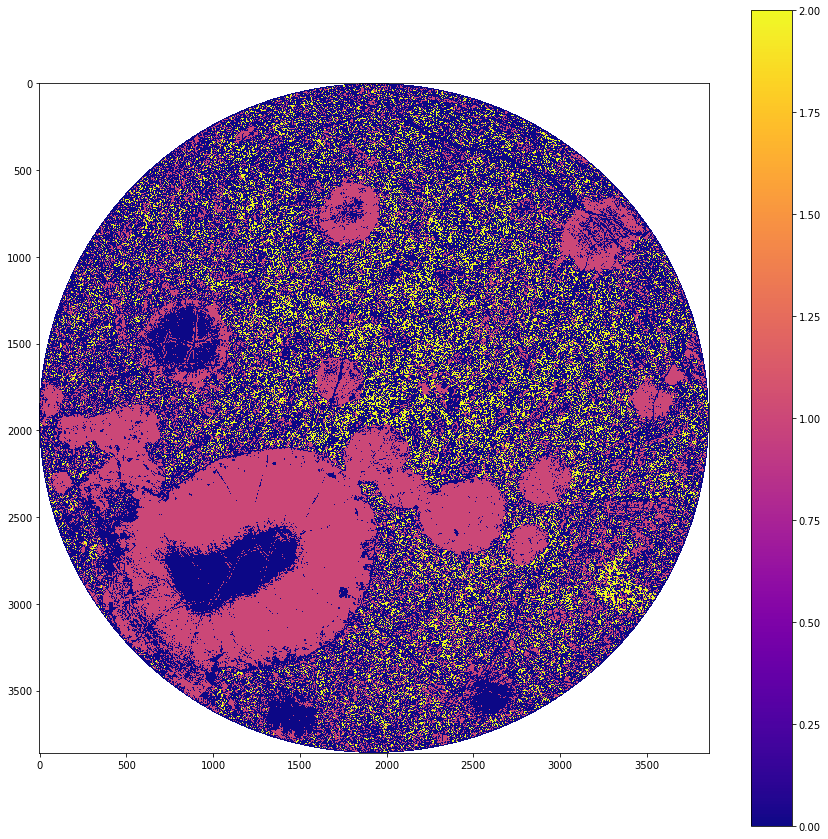

In [89]:
# footprint condition says value should be greater
# in all directions
footprint1 = np.array(
    [[1, 1, 1]
    ,[1, 0, 1]
    ,[1, 1, 1]]
)

footprint2 = np.array(
    [[1, 1, 1, 1, 1]
    ,[1, 1, 1, 1, 1]
    ,[1, 1, 0, 1, 1]
    ,[1, 1, 1, 1, 1]
    ,[1, 1, 1, 1, 1]]
)

# creates a window based on the given footprint
# to compare neighbors and replace values on 
# nearest median value
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.maximum_filter.html
newim = ndimage.median_filter(zeros, footprint=footprint2, mode='constant')

fig, ax = plt.subplots(figsize=(15, 15))

imlabeled = helpers.remove_data_based_on_radius(newim, mask_value=np.nan)

# cbar = ax.imshow(imlabeled, cmap='plasma')
cbar = ax.imshow(imlabeled, cmap='plasma')

fig.colorbar(cbar)


In [58]:
from skimage.measure import label, regionprops

In [60]:
props = regionprops(newim)

In [63]:
props[0].centroid

(2233.9592899550976, 1706.265863901545)

In [74]:
len(props)

48539

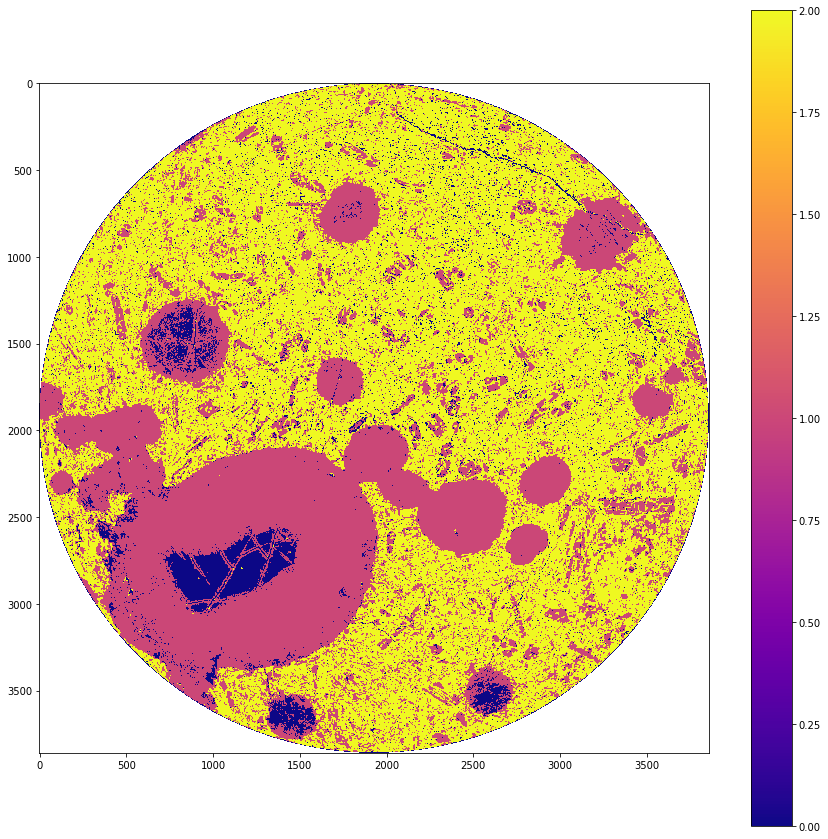

In [76]:
fig, ax = plt.subplots(figsize=(15, 15))

# imlabeled = helpers.remove_data_based_on_radius(newim, mask_value=np.nan)

# cbar = ax.imshow(imlabeled, cmap='plasma')
cbar = ax.imshow(imlabeled, cmap='plasma')

fig.colorbar(cbar)

i = 4000

# ax.plot(props[i].centroid[0], props[i].centroid[1], marker='*', markersize=15, color='cyan')

In [38]:
# TODO : why does this work when its imarr and imarr_blur
#        but doesn't work when using all the same array?

# peak1mask = (imarr < means[0]+stds) & (imarr > means[0]+stds).astype(int)

# peak2mask = (imarr < means[1]+stds) & (imarr_blur > means[1]+stds).astype(int)

'\nAt this point it seems like I can label the vesicles\nwhich appear as 0 valued here.\n\nI just need to connect the dots that are the same.\n'

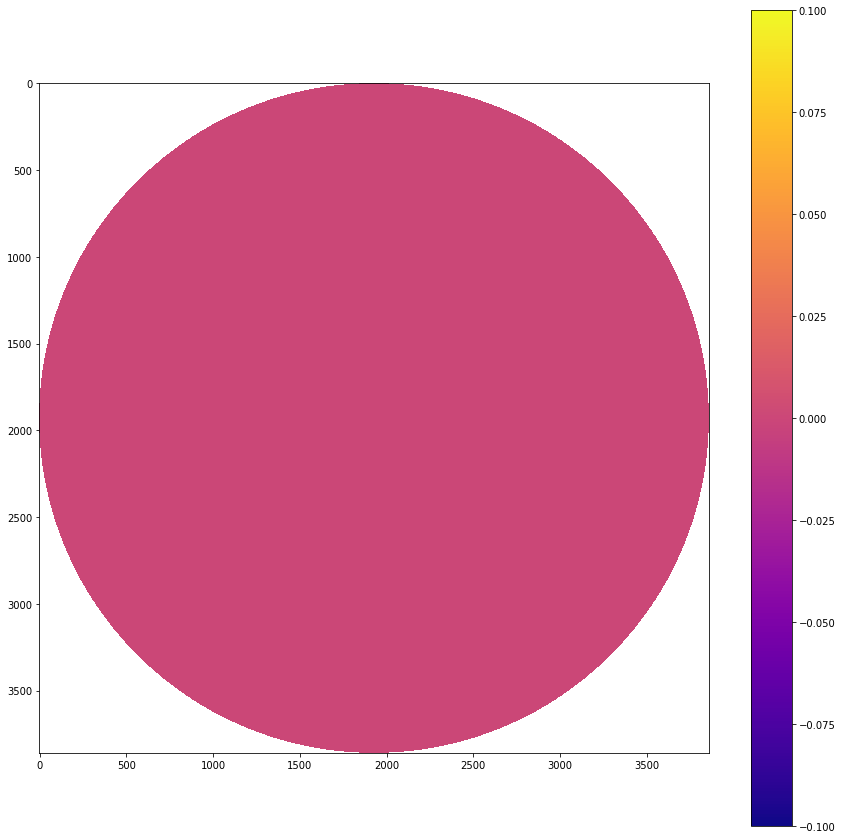

In [39]:
# # returns indices where peak1mask is 1
# x1, y1 = peak1mask.nonzero()

# zeros = np.zeros_like(imarr)
# zeros[x1, y1] = 1


# # x2, y2 = peak2mask.nonzero()
# # zeros[x2, y2] = 2

# # print(zeros.max())

# fig, ax = plt.subplots(figsize=(15, 15))

# imlabeled = helpers.remove_data_based_on_radius(zeros, mask_value=np.nan)


# # cbar = ax.imshow(imlabeled, cmap='plasma')
# cbar = ax.imshow(imlabeled, cmap='plasma')

# fig.colorbar(cbar)

# """
# At this point it seems like I can label the vesicles
# which appear as 0 valued here.

# I just need to connect the dots that are the same.
# """